In [20]:
import zipfile
path = "/content/drive/MyDrive/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

In [19]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


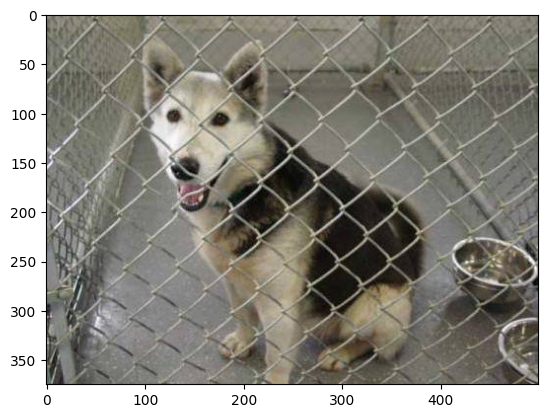

In [21]:

import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[2000]))

In [23]:
#代码创建了三个DataFrame对象train、validate和test，用于将训练、验证和测试数据集的图像路径和类别标签存储在其中
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
train = pd.DataFrame({
    "filename":dogs[:900] + cats[:900],
    "class":["dog"] * 900 + ["cat"] * 900
})
#我们会将一部分数据留出来作为验证集(小考)，在每一轮迭代后使用验证集对模型进行评估，从而了解模型的训练情况和泛化能力。通常我们会根据验证集的表现来调整模型的超参数，例如学习率、正则化系数等，以提高模型的性能。
validate = pd.DataFrame({
    "filename":dogs[900:950] + cats[900:950],
    "class":["dog"] * 50 + ["cat"] * 50
})#通过将这两个列表相加，就可以得到一个包含100个元素的列表(大考)，其中前50个元素是"dog"，后50个元素是"cat"。这个列表就是用于标记每个图片类别的标签。
test = pd.DataFrame({
    "filename":dogs[950:1000] + cats[950:1000],
    "class":["dog"] * 50 + ["cat"] * 50
})
     

Generator原理:
圖片不一次給，怕RAM爆掉

def test():
    l = [1, 2, 3, 4, 5]
    for n in l:
        yield n ** 2

t = test()   # 调用生成器函数 test()，返回一个生成器对象
print(next(t))   # 输出 1
print(next(t))   # 输出 4
print(next(t))   # 输出 9
print(next(t))   # 输出 16
  # print(next(t))   # 输出 25

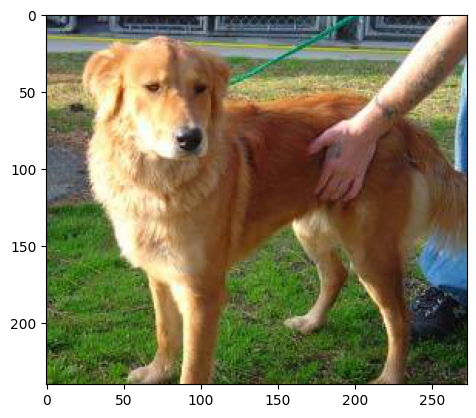

In [24]:
import numpy as np
i=np.array(Image.open(fs[1600]))
# i.shape

# plt.imshow(i[:200,...])
# plt.imshow(i[...])
# plt.imshow(i[...,::-1])

import numpy as np
i=np.array(Image.open(fs[1600]))
plt.imshow(i[...])

preprocess

caffe: 轉BGR後 - mean = [103.939, 116.779, 123.68], -1xx~+1xx間

tf: -1~1

torch: 

偷眼睛就得偷預處理

ImageDataGenerator一般會帶一個參數 rescale=1/255.0, 但我這裡是偷 我帶的是preprocessing_function

In [25]:
# 數據增強
# 妳的圖片太少的時候可以用原本圖片做出假圖片

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
# 資料增強: zoom:放大(1.2) shear:偏斜(0.2) 水平翻轉
train_datagen = ImageDataGenerator(
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 測試資料是沒有動的
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 另外一個叫做flow_from_directory
# flow_from_dataframe: 檔案路徑要叫filename 答案class
training_set = train_datagen.flow_from_dataframe(
    train,
    ".",
    # 每一張圖片都縮到(224, 224): 根據當初imagenet的訓練大小
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    # 她會直接幫妳dog/cat這字串轉成0/1
    class_mode="sparse")
validate_set = test_datagen.flow_from_dataframe(
    validate,
    ".",
    # 每一張圖片都縮到(224, 224)
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse")
test_set = test_datagen.flow_from_dataframe(
    test,
    ".",
    # 每一張圖片都縮到(112, 112)
    target_size=(224, 224),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse")

Found 1800 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


(32, 224, 224, 3)


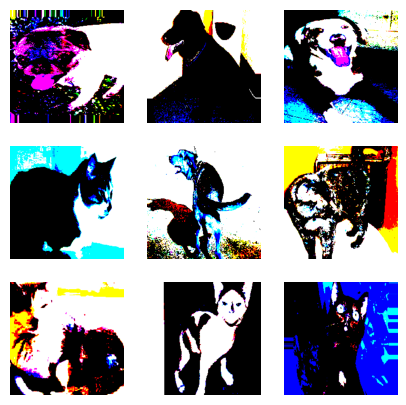

In [26]:
# 秀出訓練資料被數據增強以後產生的圖片
import matplotlib.pyplot as plt
# __next__: (圖片, 答案)
batch = training_set.__next__()[0]
print(batch.shape)
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i])
    plt.axis("off")
     

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()
     

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
for l in vgg.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()
     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [29]:

from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [30]:

# 控制訓練次數: 控制過擬合程度
# 不希望死背/看稀少, 檢查test
# 訓練次數過多反而會變差
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    ModelCheckpoint("cnn.h5", save_best_only=True),
    # 檢查test資料, 如果我10次都沒有表現更好, 停
    EarlyStopping(patience=10, restore_best_weights=True)
]
# 不想要進度條, verbose=2
model.fit(training_set,
     epochs=150,
     validation_data=validate_set,
     callbacks=callbacks,
     verbose=2)
     

Epoch 1/150
57/57 - 35s - loss: 0.4111 - accuracy: 0.8378 - val_loss: 0.1615 - val_accuracy: 0.9600 - 35s/epoch - 611ms/step
Epoch 2/150
57/57 - 32s - loss: 0.2141 - accuracy: 0.9411 - val_loss: 0.1066 - val_accuracy: 0.9700 - 32s/epoch - 557ms/step
Epoch 3/150
57/57 - 30s - loss: 0.1560 - accuracy: 0.9550 - val_loss: 0.0812 - val_accuracy: 0.9900 - 30s/epoch - 533ms/step
Epoch 4/150
57/57 - 31s - loss: 0.1355 - accuracy: 0.9544 - val_loss: 0.0697 - val_accuracy: 0.9900 - 31s/epoch - 542ms/step
Epoch 5/150
57/57 - 31s - loss: 0.1227 - accuracy: 0.9639 - val_loss: 0.0596 - val_accuracy: 0.9900 - 31s/epoch - 546ms/step
Epoch 6/150
57/57 - 30s - loss: 0.1139 - accuracy: 0.9583 - val_loss: 0.0563 - val_accuracy: 0.9800 - 30s/epoch - 533ms/step
Epoch 7/150
57/57 - 31s - loss: 0.0965 - accuracy: 0.9728 - val_loss: 0.0498 - val_accuracy: 0.9800 - 31s/epoch - 546ms/step
Epoch 8/150
57/57 - 31s - loss: 0.0947 - accuracy: 0.9728 - val_loss: 0.0465 - val_accuracy: 0.9800 - 31s/epoch - 541ms/step


In [31]:
#传入测试集数据 test_set 作为参数，模型会对测试集中的每个样本进行预测，并将预测结果与相应的真实标签进行比较，计算出模型在测试集上的损失值和准确率等评估指标
model.evaluate(x=test_set)

4/4 [==============================] - 1s 116ms/step - loss: 0.0541 - accuracy: 0.9900


[0.05407948046922684, 0.9900000095367432]

这段代码的作用是从一个数据框中获取图像数据和对应的目标标签，以便进行模型训练和测试。具体来说，函数 getdata 从数据框中遍历每个样本，读取图像数据并进行预处理，将原始图像和预处理后的图像分别保存在 img_ori 和 img_preprocess 数组中，将样本的目标标签保存在 target 数组中，最后返回三个数组作为结果。这些数组的形状分别是 (样本数, 224, 224, 3)，(样本数, 224, 224, 3) 和 (样本数,)。这些数组可以用于构建卷积神经网络模型并进行训练和测试。

如果没有这段代码，就无法从数据框中获取图像数据和对应的目标标签，就无法进行模型训练和测试。具体来说，如果没有 getdata 函数，那么就需要手动编写代码从文件系统中读取图像数据并进行预处理，将图像数据和对应的标签保存到 NumPy 数组中，这将需要更多的代码量和时间。而使用 getdata 函数可以方便地从数据框中获取图像数据和标签，并进行预处理，可以减少编写代码的工作量，并提高代码的可读性和可维护性。因此，这段代码的作用是非常重要的。

In [32]:
import numpy as np
from PIL import Image

# 定義一個函數 getdata，將 DataFrame 中的圖片轉換成 numpy array 並進行前處理
def getdata(df):
    # 初始化空列表，用於存儲原始圖片、前處理圖片和目標標籤
    img_ori, img_preprocess, target = [], [], []
    
    # 遍歷 DataFrame 中每一行的資料
    for fn, c in zip(df["filename"], df["class"]):
        # 打開圖片，將其大小調整為 (224, 224) 並轉換為 RGB 格式
        img = Image.open(fn).resize((224, 224)).convert("RGB")
        
        # 將圖片轉換為 numpy array
        img_np = np.array(img)
        
        # 將原始圖片存儲在 img_ori 列表中
        img_ori.append(img_np)
        
        # 使用 keras.applications 模塊中的 preprocess_input 函數對圖片進行預處理
        img_np_pre = preprocess_input(img_np)
        
        # 將前處理後的圖片存儲在 img_preprocess 列表中
        img_preprocess.append(img_np_pre)
        
        # 根據類別 (貓為 0，狗為 1) 設置目標標籤
        if c == "cat":
            target.append(0)
        else:
            target.append(1)
    
    # 將列表轉換為 numpy array 並返回
    return (np.array(img_ori), np.array(img_preprocess), np.array(target))

# 調用 getdata 函數，將測試集轉換為 numpy array
img_ori, x_test, y_test = getdata(test)

# 打印轉換後的圖片、前處理圖片和目標標籤的形狀
print(img_ori.shape)
print(x_test.shape)
print(y_test.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)
(100,)


In [33]:
pre = model.predict(img_ori).argmax(axis=-1)
pre
     

4/4 [==============================] - 1s 124ms/step


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [34]:

np.nonzero(y_test != pre)

(array([ 1, 22, 30, 31, 37, 79, 94, 97]),)

[ 1 22 30 31 37 79 94 97]


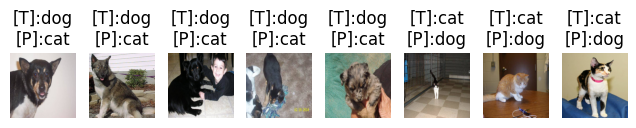

In [35]:

import numpy as np
trans = ["cat", "dog"]
idx = np.nonzero(y_test != pre)[0]
idx = idx[:100]
print(idx)
plt.figure(figsize=(10, 10))
# 預測錯誤的預測值
fp_pred = pre[idx]
# 預測錯誤的真實值
fp_true = y_test[idx]
# 預測錯誤的圖片
fp_img = img_ori[idx]
for i in range(len(idx)):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    t = "[T]:{}\n[P]:{}".format(trans[fp_true[i]], trans[fp_pred[i]])
    plt.title(t)
    plt.imshow(fp_img[i])

url:https://i2.kknews.cc/kYXbr-qongbUjDHx33rMOJx6Lafd-LuAaIf_V8U/0.jpg
1/1 [==============================] - 1s 855ms/step
cat 的機率: 0.135
dog 的機率: 0.865


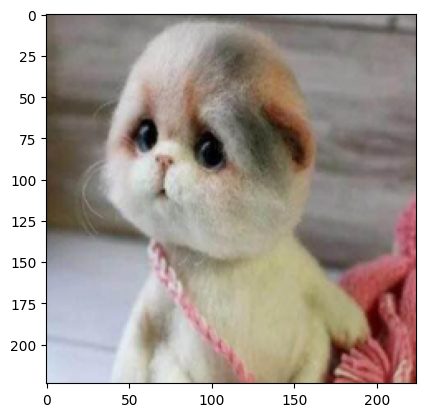

In [39]:

import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)
     